<a href="https://colab.research.google.com/github/B21-CAP0366/meater-ml/blob/main/meater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meater

Steps:
1. Acquire data
1. Data preprocessing
1. Make the model
1. Train the model
1. Plot the model
1. Save the model

## Acquire Data

Acquire data from: https://www.kaggle.com/crowww/meat-quality-assessment-based-on-deep-learning

Steps:
1. Run cells below
1. Upload `kaggle.json` to colab
1. Done. It will be downloaded to your workspace automatically

In [ ]:
from google.colab import files


print("Upload your kaggle.json")
kaggle_file = files.upload()

# Change file permission
! chmod 600 kaggle.json 
# Check or make kaggle folder
! (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle)
# Move kaggle.json to kaggle folder
! mv kaggle.json ~/.kaggle/ && echo 'Done'
# Download dataset from kaggle
! kaggle datasets download crowww/meat-quality-assessment-based-on-deep-learning

import zipfile


file_name = 'meat-quality-assessment-based-on-deep-learning.zip'
# Extract dataset zip file
with zipfile.ZipFile(file_name) as zip_file:
    zip_file.extractall('./meat-dataset/')

print('Done')

Upload your kaggle.json


Saving kaggle.json to kaggle.json
Done
100% 270M/270M [00:04<00:00, 82.8MB/s]
100% 270M/270M [00:04<00:00, 64.7MB/s]
Done


## Data Preprocessing

Steps:
1. Look at some sample pictures
1. Train, validation, and test split
1. Make generator

### Look at the data

In [ ]:
import os
import cv2 as cv


base_dir = os.path.join('meat-dataset')
fresh_meat_dir = os.path.join(base_dir, 'Fresh')
spoiled_meat_dir = os.path.join(base_dir, 'Spoiled')

# List file names in each folder
fresh_meat_names = os.listdir(fresh_meat_dir)
spoiled_meat_names = os.listdir(spoiled_meat_dir)

sample_img = cv.imread(os.path.join(fresh_meat_dir, fresh_meat_names[0]))
print('Fresh meat: {}'.format(len(fresh_meat_names)))
print('Shape: {}'.format(sample_img.shape))
print(fresh_meat_names[:5])

sample_img = cv.imread(os.path.join(spoiled_meat_dir, spoiled_meat_names[0]))
print('\nSpoiled meat: {}'.format(len(spoiled_meat_names)))
print('Shape: {}'.format(sample_img.shape))
print(spoiled_meat_names[:5])

Fresh meat: 948
Shape: (720, 1280, 3)
['test_20171017_140121D.jpg', 'test_20171017_102321D.jpg', 'test_20171016_145521D.jpg', 'test_20171016_203721D.jpg', 'test_20171016_140521D.jpg']

Spoiled meat: 948
Shape: (720, 1280, 3)
['test_20171018_143921D.jpg', 'test_20171018_150521D.jpg', 'test_20171018_052121D.jpg', 'test_20171017_201321D.jpg', 'test_20171018_194321D.jpg']


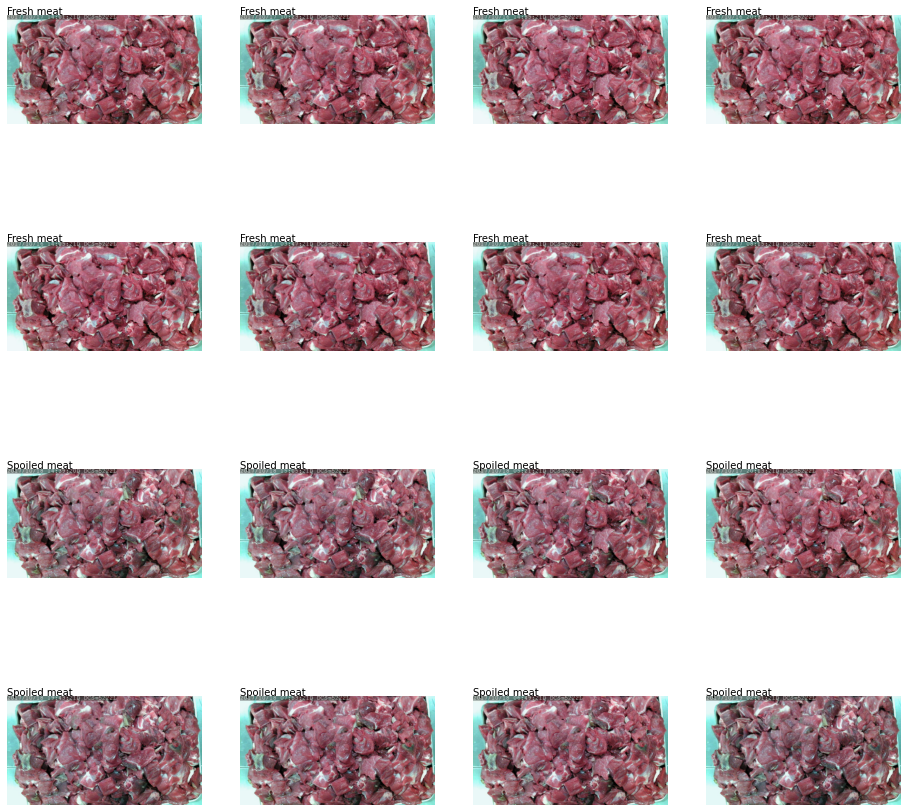

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


nrows = 4
ncols = 4

# Set up figure and size it to 4*4
fig = plt.gcf()
fig.set_size_inches(nrows*4, ncols*4)

pic_index = 8

# Get first 8 pictures in each folder
fresh_meat_pic = [os.path.join(fresh_meat_dir, fname) for fname in fresh_meat_names[:pic_index]]
spoiled_meat_pic = [os.path.join(spoiled_meat_dir, fname) for fname in spoiled_meat_names[:pic_index]]

for i, img_path in enumerate(fresh_meat_pic + spoiled_meat_pic):
    # Set text
    if i < pic_index:
        text = 'Fresh meat'
    else:
        text = 'Spoiled meat'
    
    # Setup subplot
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')  # Turn off subplot axis
    sp.text(1, 1, text)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()  # Show images

### Train, Val, Test Split

Total data: 948 + 948 = 1896

Type       | Percentage | Numbers |
-----------|------------|---------|
Train      |        80% |    1516 |
Validation |        15% |     284 |
Test       |         5% |      96 |
**Total**  |   **100%** |**1896** |

In [ ]:
# Install split folders
! pip install split-folders tqdm

In [ ]:
import splitfolders

split_folder = 'split-meat'
splitfolders.ratio(base_dir,
                   output=split_folder,
                   ratio=(0.8, 0.15, 0.05))

Copying files: 1896 files [00:00, 2453.36 files/s]


In [ ]:
train_dir = os.path.join(split_folder, 'train')
val_dir = os.path.join(split_folder, 'val')
test_dir = os.path.join(split_folder, 'test')

fresh_train_dir = os.path.join(train_dir, 'Fresh')
spoiled_train_dir = os.path.join(train_dir, 'Spoiled')

fresh_val_dir = os.path.join(val_dir, 'Fresh')
spoiled_val_dir = os.path.join(val_dir, 'Spoiled')

fresh_test_dir = os.path.join(test_dir, 'Fresh')
spoiled_test_dir = os.path.join(test_dir, 'Spoiled')

def get_len(title, fresh_dir, spoiled_dir):
    len_fresh = len(os.listdir(fresh_dir))
    len_spoiled = len(os.listdir(spoiled_dir))
    len_total = len_fresh + len_spoiled

    print('{}: {}'.format(title, len_total))
    print('Fresh: {}'.format(len_fresh))
    print('Spoiled: {}\n'.format(len_spoiled))

get_len('Train', fresh_train_dir, spoiled_train_dir)
get_len('Val', fresh_val_dir, spoiled_val_dir)
get_len('Test', fresh_test_dir, spoiled_test_dir)

Train: 1516
Fresh: 758
Spoiled: 758

Val: 284
Fresh: 142
Spoiled: 142

Test: 96
Fresh: 48
Spoiled: 48



### Make generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Make image data generator
train_datagen = ImageDataGenerator(
    rescale=1/255.0,        # Rescale the image
    rotation_range=45,      # Randomly rotating image 0-45 deg 
    width_shift_range=0.2,  # Move image around in its frame
    height_shift_range=0.2, # Move image around in its frame
    shear_range=0.2,        # Shear the image randomly up to 20%
    zoom_range=0.2,         # Zoom the image randomly up to 20%
    horizontal_flip=True,   # Flip horizontally
    vertical_flip=True,     # Flip vertically
    fill_mode='nearest',    # Fill the pixel
)

test_val_datagen = ImageDataGenerator(rescale=1/255.0)

# Make train generator
INPUT_SHAPE = (150, 150, 3)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=INPUT_SHAPE[:2],
    class_mode='binary',
    batch_size=32,
)

# Make validation generator
val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=INPUT_SHAPE[:2],
    class_mode='binary',
    batch_size=32,
)

# Make test generator
test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=INPUT_SHAPE[:2],
    class_mode='binary',
    batch_size=32,
)

Found 1516 images belonging to 2 classes.
Found 284 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


## Make the Model

### Plot the model

In [ ]:
def plot_result(train_data, val_data, title, xlabel, ylabel):
    x = range(EPOCHS)
    plt.plot(x, train_data, 'r-')
    plt.plot(x, val_data, 'b-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Train', 'Validation'])

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    x_label = 'Epochs'

    plot_result(loss, val_loss, 'Loss', x_label, 'Loss')
    plt.figure()
    plot_result(acc, val_acc, 'Accuracy', x_label, 'Accuracy')

In [ ]:
import tensorflow as tf


# Make callbacks
DESIRED_ACCURACY = 0.98

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if logs.get('accuracy') > DESIRED_ACCURACY:
            self.model.stop_training= True
            print("\nYour accuracy: {}".format(logs.get('accuracy')))
            print("Your model has reached more than {}%\n".format(DESIRED_ACCURACY*100))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                                  patience=5,)

my_callback = MyCallback()

### Original Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
EPOCHS = 15

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, my_callback]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [ ]:
model.evaluate(test_generator)

3/3 [==============================] - 2s 554ms/step - loss: 0.3986 - accuracy: 0.8021


[0.3986233174800873, 0.8020833134651184]

### Transfer Learning Model


#### Inception model

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-05-12 13:36:38--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   103MB/s    in 0.8s    

2021-05-12 13:36:39 (103 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=INPUT_SHAPE,
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(1, activation='sigmoid')(x) 

model = tf.keras.Model(pre_trained_model.input, x)

model.summary()

# Fine Tuning
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
do_fine_tuning = True #@param {type:"boolean"}

if do_fine_tuning:
    optimizer = tf.keras.optimizers.SGD(lr=0.002, momentum=0.9)
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

    # Make all the layers in the pre-trained model trainable
    for layer in pre_trained_model.layers:
        layer.trainable = True
else:
    optimizer = 'adam'

    # Make all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Train the model
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, my_callback]
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

3/3 [==============================] - 1s 387ms/step - loss: 0.1309 - accuracy: 0.9583


[0.13088257610797882, 0.9583333134651184]

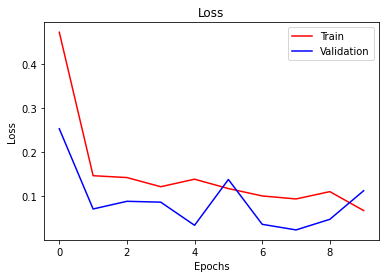

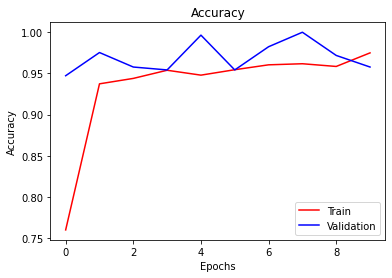

In [ ]:
plot_history(history)
model.evaluate(test_generator)

#### Mobilenet model with tensor hub

In [ ]:
import tensorflow_hub as hub


model_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}

handle_base, pixels, FV_SIZE = model_selection

IMAGE_SIZE = (pixels, pixels)

MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

# Fine Tuning
do_fine_tuning = True #@param {type:"boolean"}

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   trainable=do_fine_tuning)

print("Using {} with input size {} and output dimension {}.".format(handle_base, IMAGE_SIZE, FV_SIZE))

Using mobilenet_v2 with input size (224, 224) and output dimension 1280.


In [ ]:
print("Building model with: ", MODULE_HANDLE, '\n')

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

# Fine tuning
if do_fine_tuning:
    optimizer = tf.keras.optimizers.SGD(lr=0.002, momentum=0.9)
else:
    optimizer = 'adam'

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, my_callback]
)

Building model with:  https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
plot_history(history)
model.evaluate(test_generator)